In [1]:
## import all packages and libraries necessary
import nilearn
import nibabel as nb
import matplotlib.pyplot as plt
from nilearn import plotting, input_data, masking, signal
from nilearn.image import smooth_img
import pandas as pd 
from nilearn.image import mean_img
from nilearn.plotting import plot_img
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting
import nibabel as nb
import numpy as np
import scipy as sc
from nilearn.plotting import view_img_on_surf

/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
## to check how one subject data looks, to understand the voxel size and look at time series data, just to know some intital details
## not exactly necessary to perform
fmri_filename = ('/data/neuralabc/paujhe/AVPT_CCHD/derivatives/sub-avpt010/func/sub-avpt010_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz') # get the directory of the file
fmri_img = nb.load ('/data/neuralabc/paujhe/AVPT_CCHD/derivatives/sub-avpt010/func/sub-avpt010_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz') #load the NIFTI image
voxel_sizes = fmri_img.header.get_zooms() # to get the voxel resolution
print(f'Voxel sizes: {voxel_sizes}')

Voxel sizes: (3.0, 3.0, 3.0, 2.5999978)


(65, 77, 65, 200)


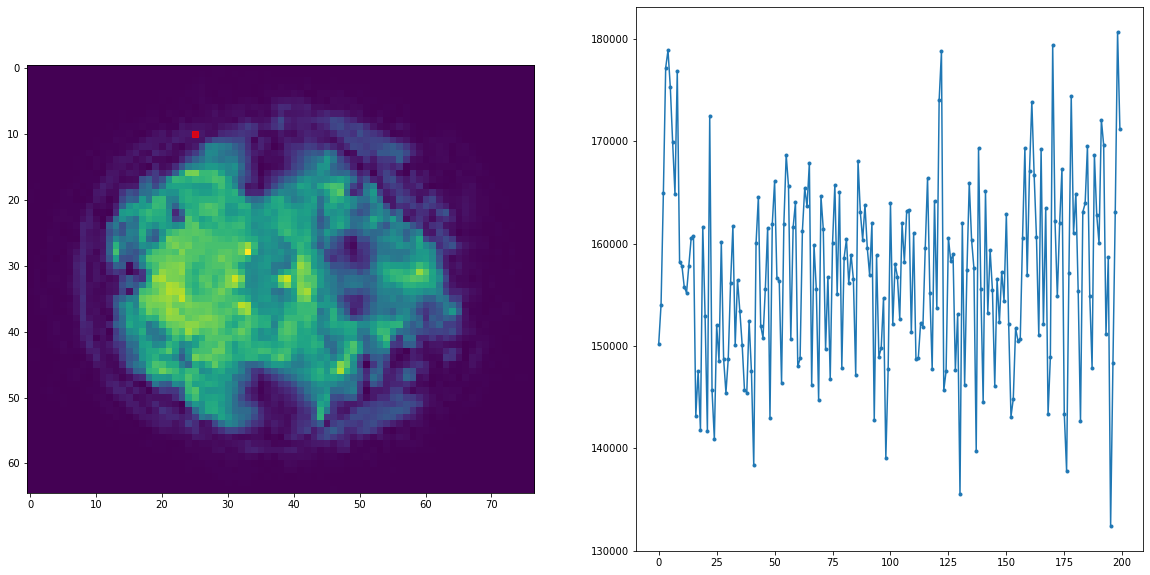

In [4]:
## to check how the BOLD signal looks like over time 
checkdata = fmri_img.get_fdata()
vox_idx_x = 10
vox_idx_y = 25
vox_idx_z = 20
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(checkdata[:,:,20,5])
plt.plot(vox_idx_y,vox_idx_x,'rs',alpha=0.75) #here we reversed x and y to plot the location of the point that we will sample the timeseries from because "x" on the plot is the "y" in the brain
# plt.figure() 
plt.subplot(1,2,2)
plt.plot(checkdata[vox_idx_x,vox_idx_y,vox_idx_z,:],'.-') #plot the timeseries data
print(checkdata.shape)

In [3]:
group1 = 'avpt' #load the experimental group name folder
group2 = 'cchd' #load the control group name folder
group1_sub_ids = ['010', '025', '034', '035','050', '051', '093', '120','153', '163', '169', '273', '275', '279', '281', '282', '283', '284', '285', '287', '288', '289', '290', '291', '292', '293', '294', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324']
group2_sub_ids = ['001', '002', '003', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016',  '017', '018', '019', '020', '021', '022', '023', '025', '026', '027', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043',  '044', '045', '046', '047', '048', '049', '050', '051','052', '053', '056', '057']
print(len(group1_sub_ids))
print(len(group2_sub_ids))

55
52


In [4]:
# creating a seed mask in cerebellum by drawing the region of interest with 8mm radius with NIFTIMasker
from nilearn.input_data import NiftiMasker
from nilearn.input_data import NiftiSpheresMasker
cereb = [(6,-63,-15)]
seed_masker = NiftiSpheresMasker(
    cereb,
    radius=8,
    detrend=True,
    standardize=True,
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)

In [50]:
# loading the entire group data for AVPT (preterm group)
group1_data = []
confounds1_data = {}
count=0
for sub_id in group1_sub_ids: #the list group1_data, consists of all the preterm subjects preprocessed BOLD signal. Dictionary confounds_data has individual dataframes of certain confounds as mentioned below.  
    img_fname_base1 = f'/data/neuralabc/paujhe/AVPT_CCHD/derivatives/sub-{group1}{sub_id}/func/sub-{group1}{sub_id}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    group1_data.append(nb.load(img_fname_base1)) #load the NIFTI file and then stack it on top of other
    confounds_fname_base1 = f'/data/neuralabc/paujhe/AVPT_CCHD/derivatives/sub-{group1}{sub_id}/func/sub-{group1}{sub_id}_task-rest_desc-confounds_timeseries.tsv'
    confounds_df1 = pd.read_csv(confounds_fname_base1,delimiter='\t')
    confounds_df1 = confounds_df1[['global_signal','global_signal_derivative1', 'global_signal_power2', 'global_signal_derivative1_power2', 'csf', 'white_matter','csf_wm', 'rot_x', 'rot_y', 'rot_z']].replace(np.nan, 0) #if we had loads of confounds... we could choose to use a only subset of the confounds here to select the "classic" confounds
    confounds1_data[count]=confounds_df1
    count = count+1
                       

In [54]:
# loading the entire group data for CCHD (control group)
group2_data = []
confounds2_data = {}
count1 = 0
for sub_id in group2_sub_ids:#the list group2_data, consists of all the control subjects preprocessed BOLD signal. Dictionary confounds_data has individual dataframes of certain confounds as mentioned below.
    img_fname_base2 = f'/data/neuralabc/paujhe/AVPT_CCHD/derivatives/sub-{group2}{sub_id}/func/sub-{group2}{sub_id}_task-rest_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
    group2_data.append(nb.load(img_fname_base2)) #load the NIFTI file and then stack it on top of other
    confounds_fname_base2 = f'/data/neuralabc/paujhe/AVPT_CCHD/derivatives/sub-{group2}{sub_id}/func/sub-{group2}{sub_id}_task-rest_desc-confounds_timeseries.tsv'
    confounds_df2 = pd.read_csv(confounds_fname_base2,delimiter='\t')
    confounds_df2 = confounds_df2[['global_signal','global_signal_derivative1', 'global_signal_power2', 'global_signal_derivative1_power2', 'csf', 'white_matter','csf_wm', 'rot_x', 'rot_y', 'rot_z']].replace(np.nan, 0) #if we had loads of confounds... we could choose to use a only subset of the confounds here to select the "classic" confounds
    confounds2_data[count1]=confounds_df2
    count1 = count1+1

In [57]:
group1_seedTime_Series = []
#extracting the mean time series value inside the ROI from all the subjects in group 1
for i in range(0,55):
    seed_time_series1= seed_masker.fit_transform(group1_data[i], confounds = [confounds1_data[i]])
    group1_seedTime_Series.append(seed_time_series1)

In [58]:
np.save('group1_seedTime_Series.npy',group1_seedTime_Series) #np.load to retrieve the data without running this again as it takes some time to process 

In [59]:
group2_seedTime_Series = []
#extracting the mean time series value inside the ROI from all the subjects in group 2
for ts in range(0,52):
    seed_time_series2=seed_masker.fit_transform(group2_data[ts], confounds = [confounds2_data[ts]])
    group2_seedTime_Series.append(seed_time_series2)

In [60]:
np.save('group2_seedTime_Series.npy',group2_seedTime_Series) #np.load to retrieve data without running again as it takes time to process

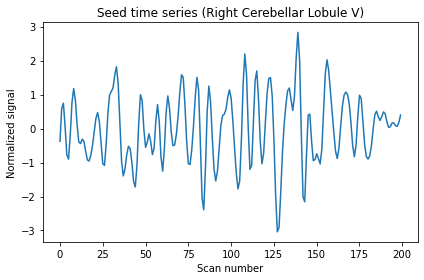

In [361]:
# plotting the mean seed ROI signal over 200 timepoints all one subject in group 1 preterm
plt.plot(group1_seedTime_Series[5]) 
plt.title("Seed time series (Right Cerebellar Lobule V)")
plt.xlabel("Scan number")
plt.ylabel("Normalized signal")
plt.tight_layout()

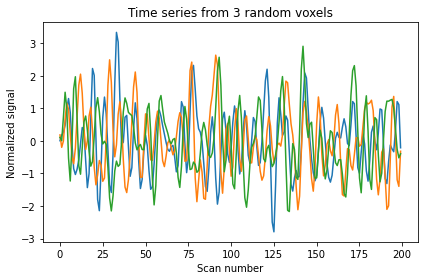

In [364]:
# random checks for how the mean signal looks from random 3 voxels in one subject over 200 timepoints
plt.plot(group1_brain_time_series[5][:, [10, 45, 100]])
plt.title("Time series from 3 random voxels")
plt.xlabel("Scan number")
plt.ylabel("Normalized signal")
plt.tight_layout()

In [61]:
from nilearn.input_data import NiftiMasker
# creating a brain mask foracquiring smoothed data from the entire dataset
brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True,
    standardize=True,
    low_pass=0.1,
    high_pass=0.01,
    t_r=2,
    memory="nilearn_cache",
    memory_level=1,
    verbose=0,
)

In [62]:
group1_brain_time_series = []
#extracting voxel wise mean signal from the brain mask for groupa 1 subjects.
for j in range(0,55):
    brain_time_series1 = brain_masker.fit_transform(group1_data[j], confounds = [confounds1_data[j]])
    group1_brain_time_series.append(brain_time_series1)


/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,
/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team w

/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,
/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team w

/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,
/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team w

In [72]:
group2_brain_time_series = 
#extracting voxel wise mean signal from the brain mask for groupa 2 subjects.
for rs in range(0,52):
    brain_time_series2 = brain_masker.fit_transform(group2_data[rs], confounds = [confounds2_data[rs]])
    group2_brain_time_series.append(brain_time_series2)

/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,
/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.50s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team w

/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,
/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/input_data/nifti_masker.py:443: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team w

In [81]:
group1_seed_to_voxel_correlations = []
#correlation between the cerebellum seed region and whole-brain voxels for group 1. takes longer time to process. The signals have been variance-standardized during extraction. To have them standardized to norm unit, we further have to divide the result by the length of the time series 
for k in range(0,55):
    seed_to_voxel_correlations1 = (np.dot(group1_brain_time_series[k].T, group1_seedTime_Series[k]) / group1_seedTime_Series[k].shape[0])
    group1_seed_to_voxel_correlations.append(seed_to_voxel_correlations1)

In [82]:
group2_seed_to_voxel_correlations = []
#correlation between the cerebellum seed region and whole-brain voxels for group 2. takes longer time to process. The signals have been variance-standardized during extraction. To have them standardized to norm unit, we further have to divide the result by the length of the time series  
for ks in range(0,52):
    seed_to_voxel_correlations2 =(np.dot(group2_brain_time_series[ks].T, group2_seedTime_Series[ks])/ group2_seedTime_Series[ks].shape[0])
    group2_seed_to_voxel_correlations.append(seed_to_voxel_correlations2)

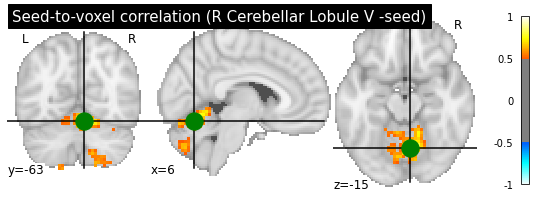

In [374]:
from nilearn import plotting
#plotting the correlation in one subject writh respect to the seed region
seed_to_voxel_correlations_imgcheck = brain_masker.inverse_transform(group1_seed_to_voxel_correlations[5].T)
display = plotting.plot_stat_map(
    seed_to_voxel_correlations_imgcheck,
    threshold=0.5,
    vmax=1,
    cut_coords=cereb[0],
    title="Seed-to-voxel correlation (R Cerebellar Lobule V -seed)",
)
display.add_markers(
    marker_coords= cereb, marker_color="g", marker_size=300
)
# At last, we save the plot as pdf.
display.savefig("cereb_seed_correlation.pdf")

In [83]:
group1_seed_to_voxel_correlations_fisher_z =[]
# Transforming the correlation to z-score values for each participant in group1, giving us seed to voxel z scores for each voxel
for l in range(0,55):
    seed_to_voxel_correlations_fisher_z1 = np.arctanh(group1_seed_to_voxel_correlations[l])
    group1_seed_to_voxel_correlations_fisher_z.append(seed_to_voxel_correlations_fisher_z1)

In [84]:
group2_seed_to_voxel_correlations_fisher_z = []
# Transforming the correlation to z-score values for each participant in group2, giving us seed to voxel z scores for each voxel
for x in range(0,52):
    seed_to_voxel_correlations_fisher_z2 = np.arctanh(group2_seed_to_voxel_correlations[x])
    group2_seed_to_voxel_correlations_fisher_z.append(seed_to_voxel_correlations_fisher_z2)

In [108]:
#saving the z score maps in NITFI files. few subjects were having difficulty in transforming as total number of voxels were different from the rest of the subjecs' data
# by one or two voxels. Even tried to find if there are any Nan values which revealed no Nan values. so went ahead and trnasformed only those which 
for ys in range(1,16):
    seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(group1_seed_to_voxel_correlations_fisher_z[ys].T)
    seed_to_voxel_correlations_fisher_z_img.to_filename(f'/data/neuralabc/paujhe/AVPT_CCHD/z_scores/{group1}_{group1_sub_ids[ys]}_z.nii.gz')  

In [109]:
#saving the z score maps in NITFI files. few subjects were having difficulty in transforming as total number of voxels were different from the rest of the subjecs' data
# by one or two voxels. Even tried to find if there are any Nan values which revealed no Nan values. so went ahead and trnasformed only those which 
for ys in range(17,38):
    seed_to_voxel_correlations_fisher_z_img1 = brain_masker.inverse_transform(group1_seed_to_voxel_correlations_fisher_z[ys].T)
    seed_to_voxel_correlations_fisher_z_img1.to_filename(f'/data/neuralabc/paujhe/AVPT_CCHD/z_scores/{group1}_{group1_sub_ids[ys]}_z.nii.gz')

In [110]:
#saving the z score maps in NITFI files. few subjects were having difficulty in transforming as total number of voxels were different from the rest of the subjecs' data
# by one or two voxels. Even tried to find if there are any Nan values which revealed no Nan values. so went ahead and trnasformed only those which 
for ys in range(39,43):
    seed_to_voxel_correlations_fisher_z_img1 = brain_masker.inverse_transform(group1_seed_to_voxel_correlations_fisher_z[ys].T)
    seed_to_voxel_correlations_fisher_z_img1.to_filename(f'/data/neuralabc/paujhe/AVPT_CCHD/z_scores/{group1}_{group1_sub_ids[ys]}_z.nii.gz')

In [111]:
#saving the z score maps in NITFI files. few subjects were having difficulty in transforming as total number of voxels were different from the rest of the subjecs' data
# by one or two voxels. Even tried to find if there are any Nan values which revealed no Nan values. so went ahead and trnasformed only those which 
for ys in range(44,55):
    seed_to_voxel_correlations_fisher_z_img1 = brain_masker.inverse_transform(group1_seed_to_voxel_correlations_fisher_z[ys].T)
    seed_to_voxel_correlations_fisher_z_img1.to_filename(f'/data/neuralabc/paujhe/AVPT_CCHD/z_scores/{group1}_{group1_sub_ids[ys]}_z.nii.gz')

In [162]:
#saving the z score maps in NITFI files. few subjects were having difficulty in transforming as total number of voxels were different from the rest of the subjecs' data
# by one or two voxels. Even tried to find if there are any Nan values which revealed no Nan values. so went ahead and trnasformed only those which 
for ys in range(40,52):
    seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(group2_seed_to_voxel_correlations_fisher_z[ys].T)
    seed_to_voxel_correlations_fisher_z_img.to_filename(f'/data/neuralabc/paujhe/AVPT_CCHD/z_scores/{group2}_{group2_sub_ids[ys]}_z.nii.gz')

In [ ]:
# So now we have NIFTI files of z-scores maps for each subject. due to transformation problem, we ended up having 51 subjects for preterm and 37 subjects for control group
# loading them separately, sorting them accordingly and creating concatenated iamges of each group, stacked one after other, to create a 4D array

In [323]:
folder_path_g1 = '/data/neuralabc/paujhe/AVPT_CCHD/z_scores/avpt'
folder_path_g2 = '/data/neuralabc/paujhe/AVPT_CCHD/z_scores/cchd'

In [324]:
import os
file_names_group1 = os.listdir(folder_path_g1)
file_names_group2 = os.listdir(folder_path_g2)
file_names_group1 = [f for f in file_names_group1 if f.endswith('.nii.gz')]
file_names_group2 = [f for f in file_names_group2 if f.endswith('.nii.gz')]
file_names_group1 = sorted(file_names_group1)
file_names_group2 = sorted(file_names_group2)
file_paths_group1 = [os.path.join(folder_path_g1, f) for f in file_names_group1]
file_paths_group2 = [os.path.join(folder_path_g2, f) for f in file_names_group2]

In [276]:
from nilearn.image import mean_img, math_img, concat_imgs
concatenated_img_group1 = concat_imgs(file_paths_group1)
concatenated_img_group2 = concat_imgs(file_paths_group2)

In [325]:
array1 = np.array(file_paths_group1)
array2 = np.array(file_paths_group2)

In [328]:
all_List_result = np.concatenate((array1,array2))

In [288]:
#creating the design matrix for SecondLevel analysis
group_labels = np.concatenate((np.zeros(len(file_paths_group1)), np.ones(len(file_paths_group2))), axis=0)
df = pd.DataFrame({'Group': group_labels, 'Intercept': 1}) #design_matrix

In [330]:
#Fit the result into the SecondLevel model and that performs a  two-sample t test which we convert to z-scores for our ease.
second_level_model = SecondLevelModel()
second_level_model = second_level_model.fit(all_List_result.tolist(),design_matrix=df)

In [333]:
z_map = second_level_model.compute_contrast([1, -1], output_type='z_score') #final z-score map showing group difference bettwen two groups. higher values mean those areas have more seed to whole-brain voixel correlation than the other group and wise-verse.

/opt/quarantine/anaconda3/2020.11/install/lib/python3.8/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(X <= 0, 0, 1. / X)



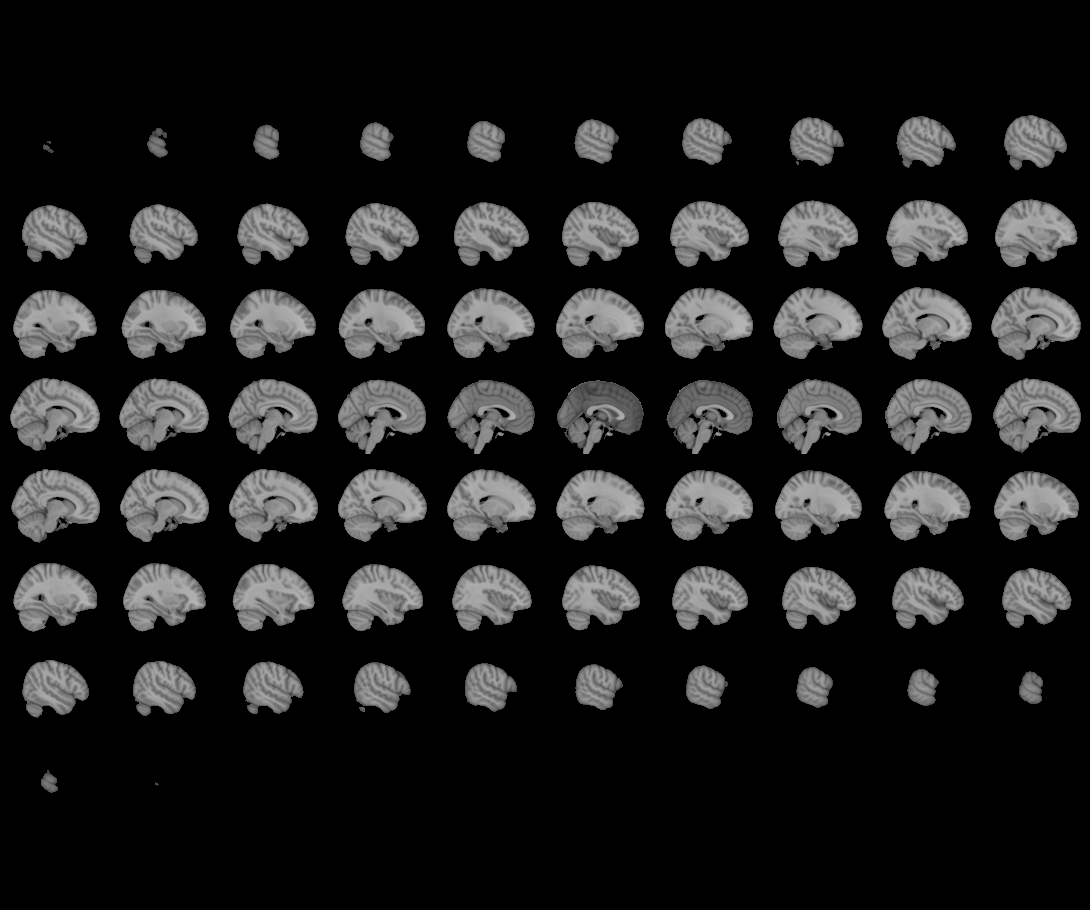
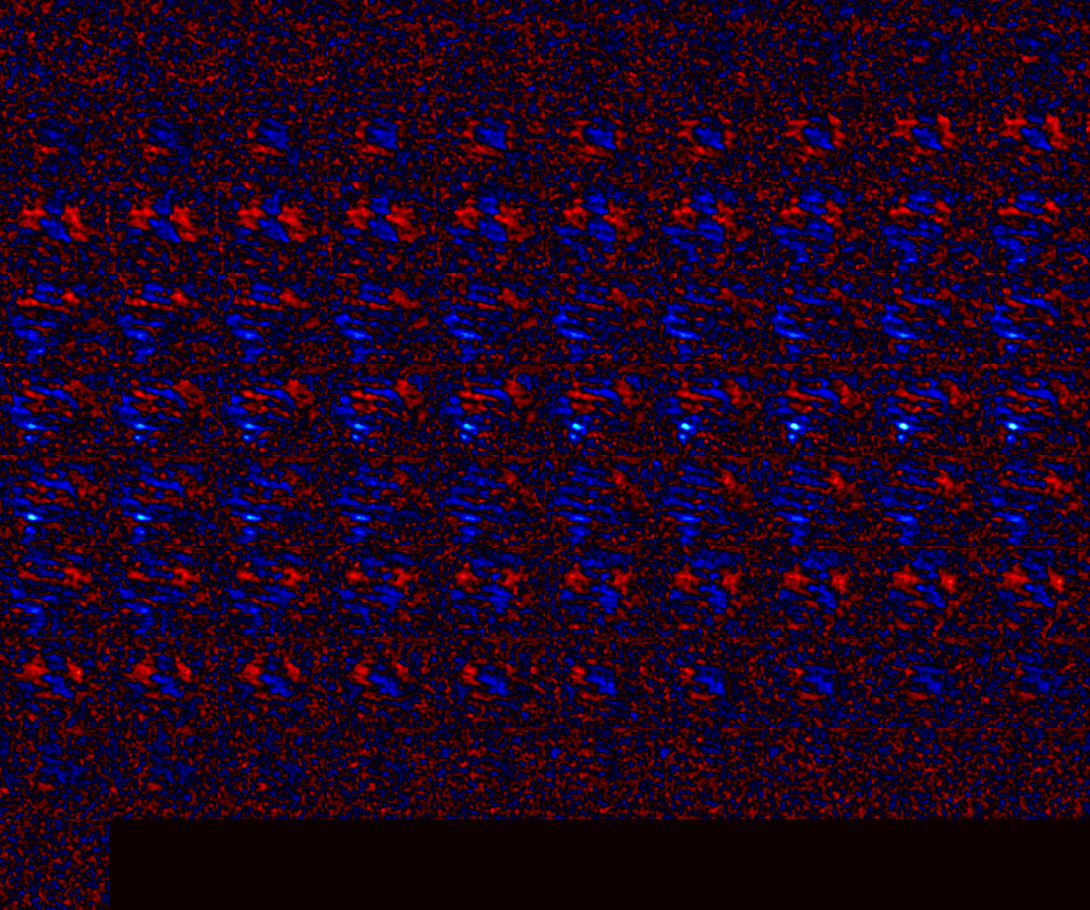

In [347]:
nilearn.plotting.view_img(z_map)

Uncorrected alpha = 0.0001 threshold: 3.891


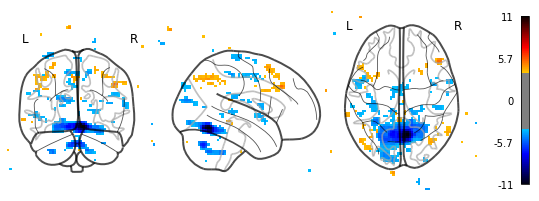

In [375]:
#plotting the uncorrected z-map for group difference.
from nilearn.glm.thresholding import threshold_stats_img
_, fpr_thresh = threshold_stats_img(z_map, alpha=.0001, height_control='fpr')
print('Uncorrected alpha = 0.0001 threshold: %.3f' % fpr_thresh)

plotting.plot_glass_brain(z_map, colorbar=True, threshold=fpr_thresh,plot_abs=False)


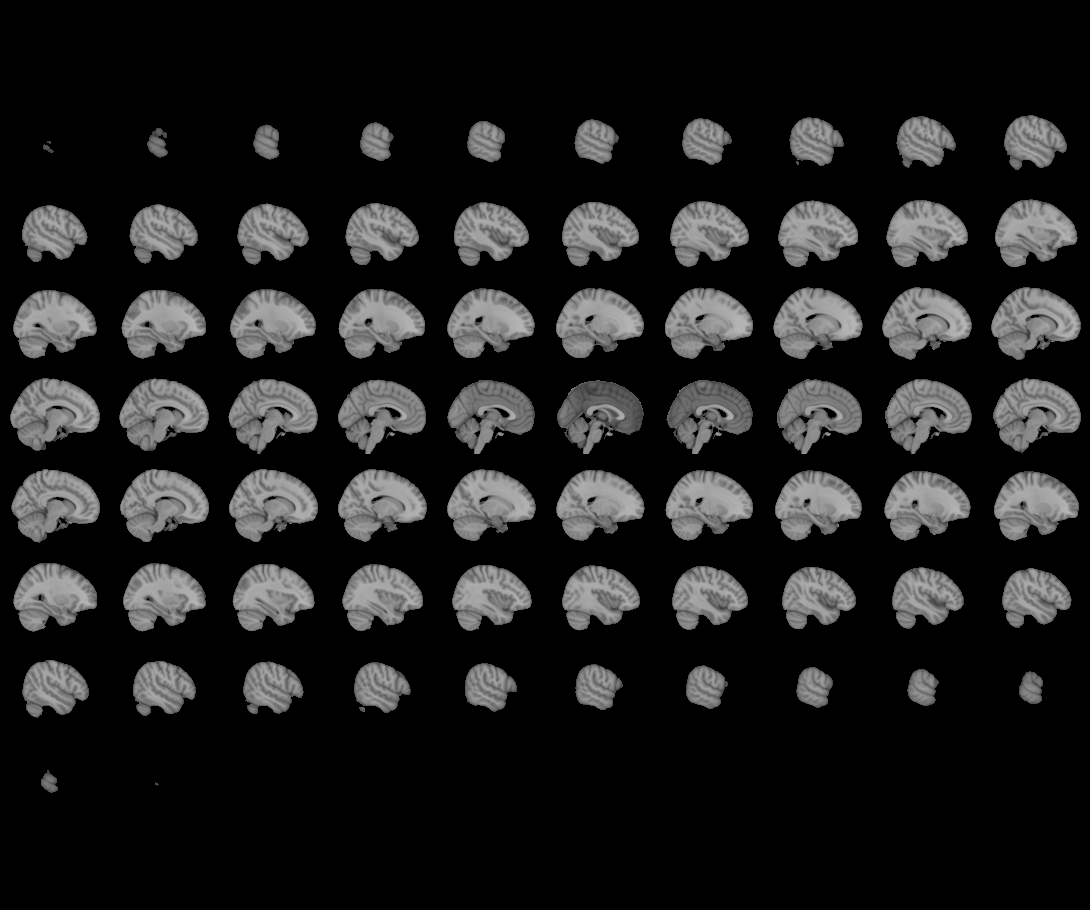
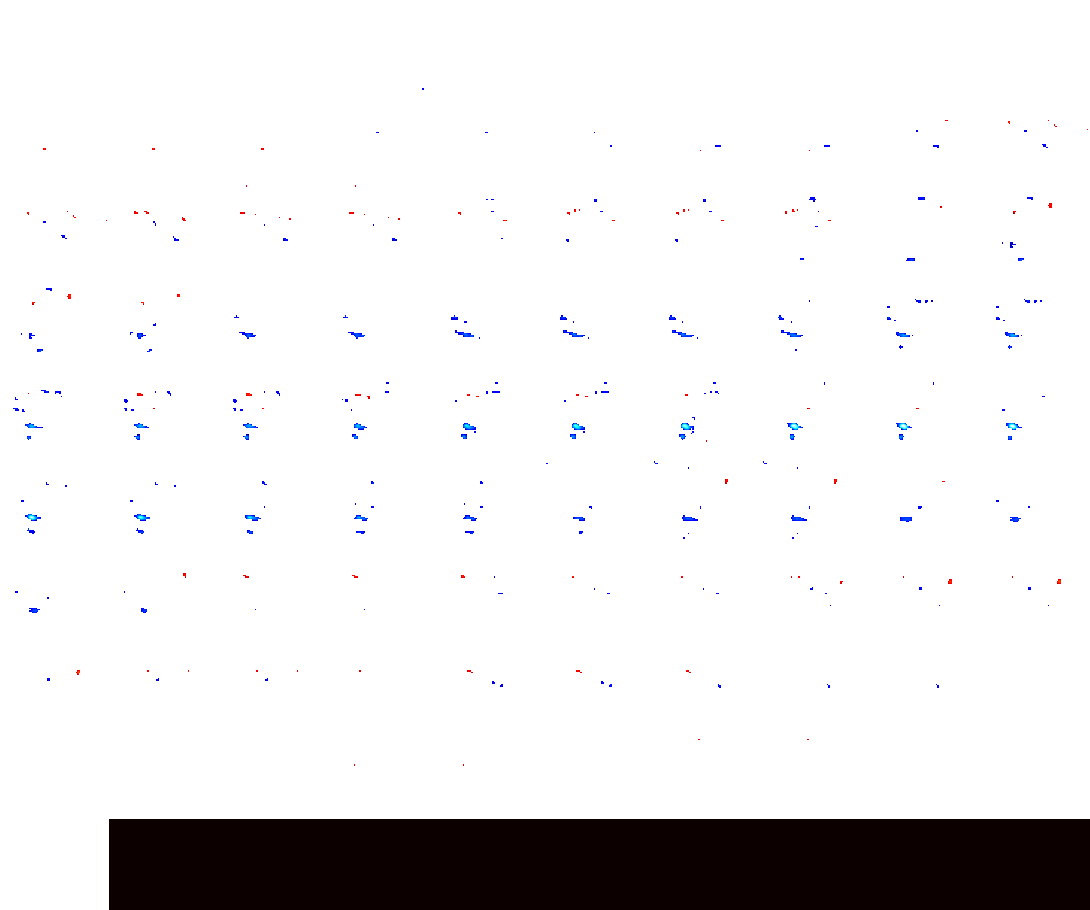

In [356]:
plotting.view_img(z_map,threshold=fpr_thresh)

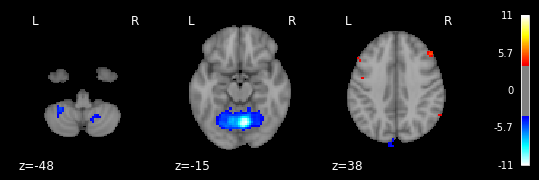

In [357]:
plotting.plot_stat_map(z_map, threshold=fpr_thresh,
              display_mode='z', cut_coords=3, black_bg=True)


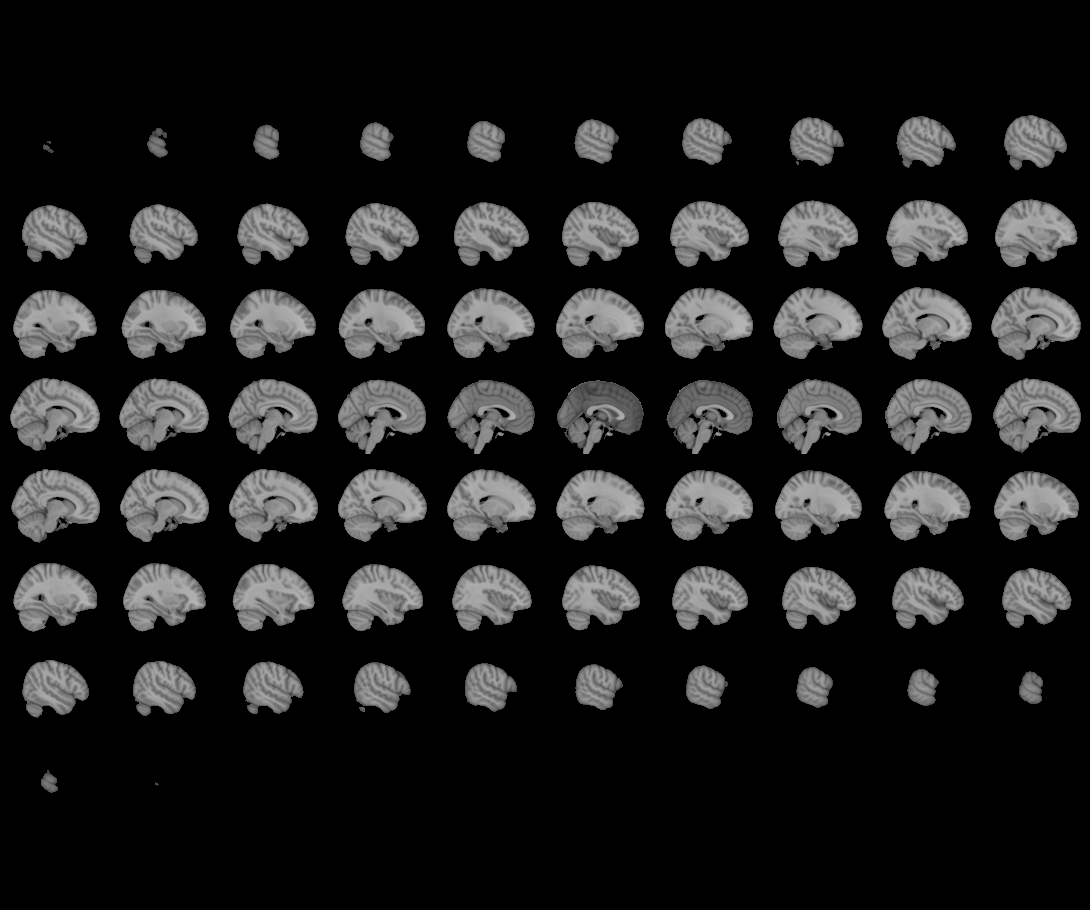
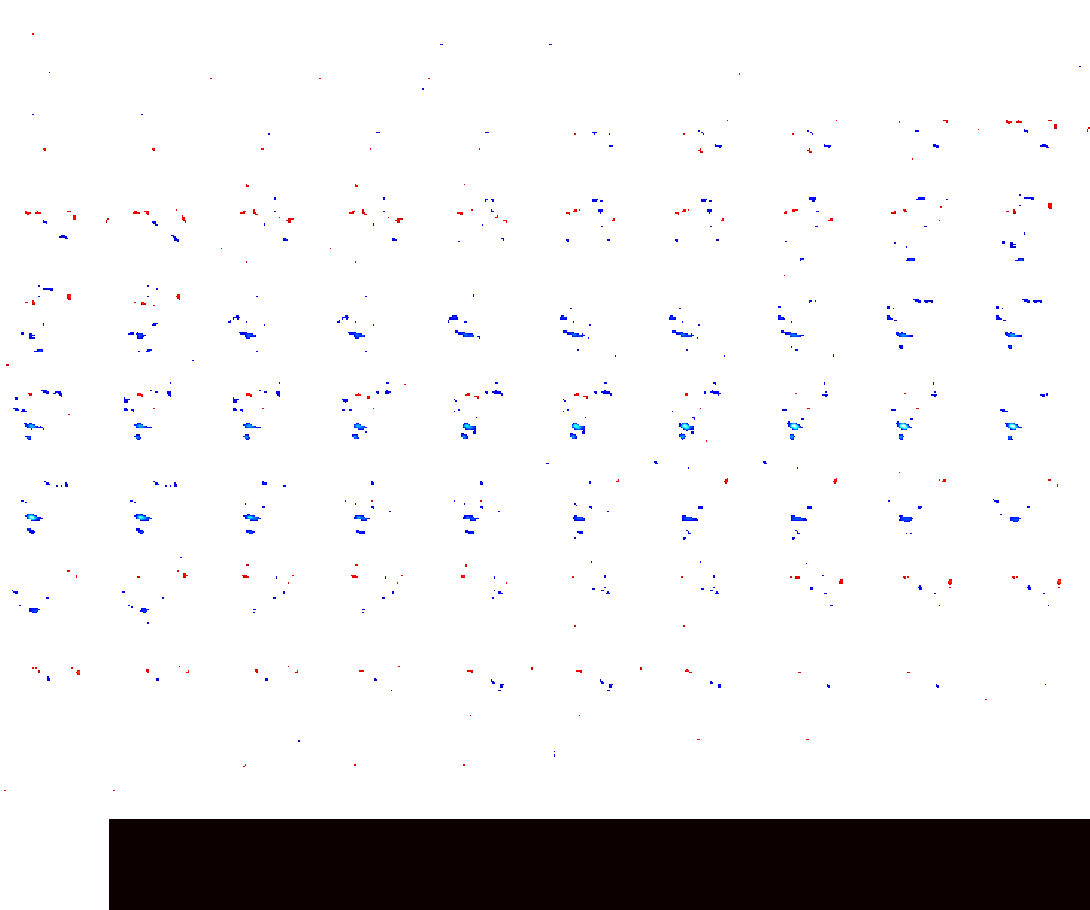

In [377]:
plotting.view_img(z_map,threshold=fdr_thresh)

False Discovery rate = 0.05 threshold: 3.624


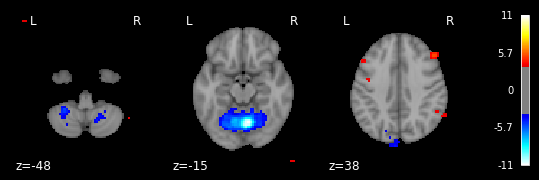

In [378]:
#plotting the fdr corrected z-map for group difference. Clusters surviving p<0.05 are significant.
_, fdr_thresh = threshold_stats_img(z_map, alpha=.05, height_control='fdr')
print('False Discovery rate = 0.05 threshold: %.3f' % fdr_thresh)

plotting.plot_stat_map(z_map, threshold=fdr_thresh,
              display_mode='z', cut_coords=3, black_bg=True)

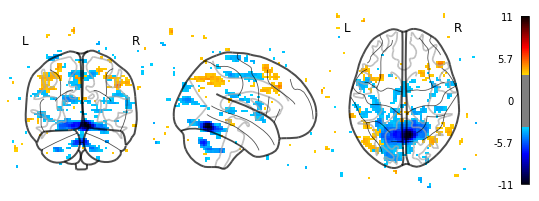

In [376]:
plotting.plot_glass_brain(z_map, colorbar=True, threshold=fdr_thresh,plot_abs=False)

Bonferroni correction (FWE) alpha = 0.05 threshold: 5.248


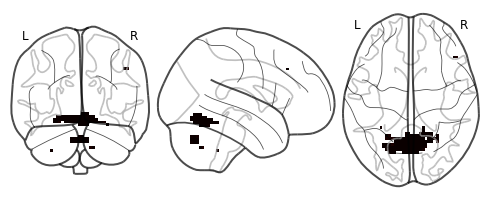

In [360]:
#No voxel cluster survived after Bonferroni correction.
_, bonf_thresh = threshold_stats_img(z_map, alpha=.05, height_control='bonferroni')
print('Bonferroni correction (FWE) alpha = 0.05 threshold: %.3f' % bonf_thresh)

plotting.plot_glass_brain(z_map, threshold=bonf_thresh)